#ANOMALY DETECTIONS

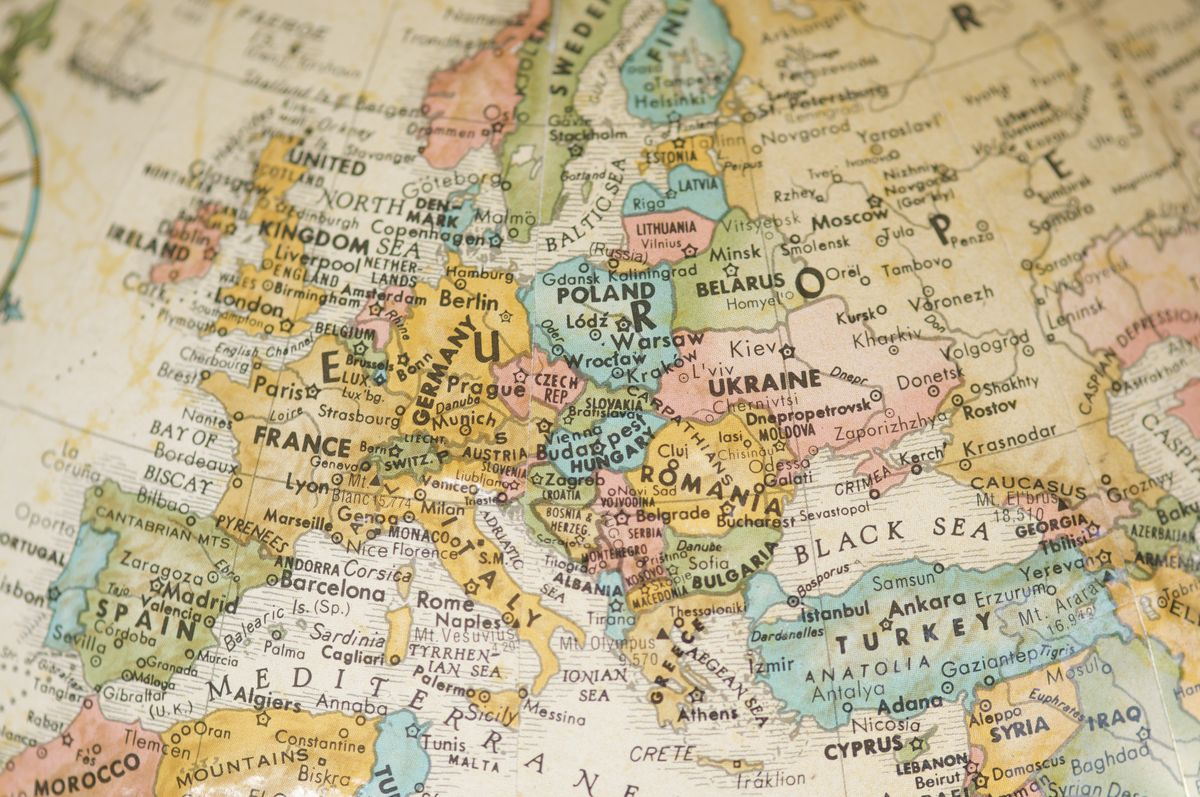

Data yang akan kita gunakan untuk membangun model anomali detection adalah data suhu yang ada di eropa dalam kurun waktu 1981 sampai 2010 yang dirata rata perbulannya, Data suhu yang diukur pada ketinggian 2 meter di atas permukaan tanah. pada dataset terdapat dua data suhu yaitu suhu di eropa dan di dunia, sedangkan yang akan kita pakai hanyalah suhu yang ada di eropa. kita akan mendeteksi selama kurun waktu 1981 sampai 2010.  Menggunakan satu set data suhu dapat mempermudah analisis karena fokus pada wilayah geografis yang lebih kecil. Ini dapat menyederhanakan proses pemodelan dan memudahkan interpretasi hasil deteksi anomali.

##IMPORT DATA

In [ ]:
import pandas as pd
import numpy as np
dataku = pd.read_csv('/content/Data_for_month_10_2016_plot_3.csv')
dataku.head()

,Month,Global,European
0,197901,-0.1718,-2.5024
1,197902,-0.4834,-1.4039
2,197903,-0.2809,0.0308
3,197904,-0.3251,-1.8235
4,197905,-0.2508,0.2225


##DATA UNDERSTANDING

In [ ]:
dataku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     454 non-null    int64  
 1   Global    454 non-null    float64
 2   European  454 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 10.8 KB


In [ ]:
dataku.describe()

,Month,Global,European
count,454.000000,454.000000,454.000000
mean,199748.328194,0.042935,0.078203
std,1093.259567,0.244447,1.260307
min,197901.000000,-0.501400,-5.605400
25%,198806.250000,-0.137800,-0.575550
50%,199711.500000,0.018350,0.162550
75%,200704.750000,0.230250,0.796900
max,201610.000000,0.863600,4.634100


In [ ]:
dataku.shape

(454, 3)

##DATA PRE-PROCESSING

In [ ]:
dataku.isnull().sum()

Month       0
Global      0
European    0
dtype: int64

In [ ]:
dataku.duplicated().sum()

0

In [ ]:
dt = dataku.drop(columns='Global', axis=1)
dt.head()

,Month,European
0,197901,-2.5024
1,197902,-1.4039
2,197903,0.0308
3,197904,-1.8235
4,197905,0.2225


##OUTLIER PERCENTILE

In [ ]:
percentile_95 = np.percentile(dt['European'], 95, method='median_unbiased')
percentile_5 = np.percentile(dt['European'], 5, method='median_unbiased')
greater_than_95 = (dt[['European']] > percentile_95)
smaller_than_5 = (dt[['European']] < percentile_5)

In [ ]:
dt['colors'] = np.where(greater_than_95,'r',np.where(smaller_than_5,'r','b'))

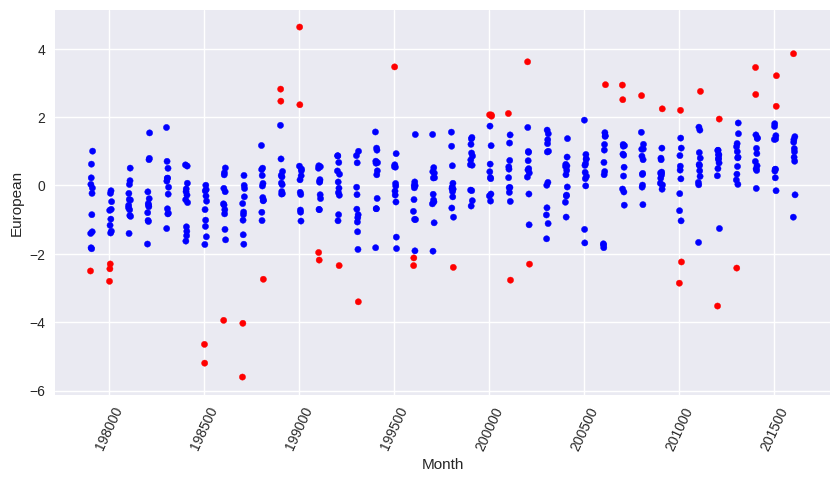

In [ ]:
import matplotlib.pyplot as plt
dt.plot.scatter(x='Month',y='European',c = dt['colors'].apply(lambda x: dict(r='red', b='blue')[x]),
           figsize=(10, 5),    title='', xlabel='Month', ylabel='European')
plt.xticks(rotation=65);

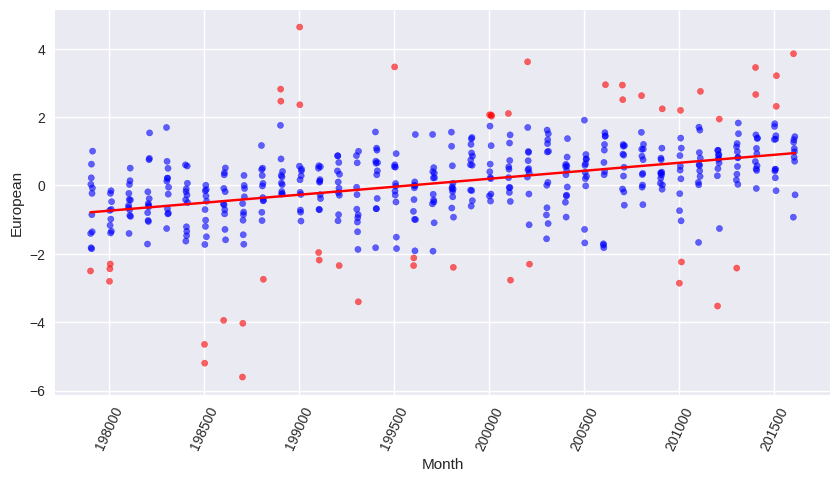

In [ ]:
#Pendekatan Statistik dengan Analisis Regresi
from sklearn.linear_model import LinearRegression

LinearRegression_model = LinearRegression()
LinearRegression_model.fit(dt[['Month']], dt[['European']])
ax = dt.plot.scatter(x='Month', y='European',
c=dt['colors'].apply(lambda x: dict(r='red', b='blue')[x]), alpha=.6, figsize=(10, 5),
    title='', xlabel='Month', ylabel='European')
reg_prediction = LinearRegression_model.predict(dt[['Month']])
ax.plot(dt['Month'], reg_prediction, c='r')
plt.xticks(rotation=65);

##LOF METHOD

Percobaan Pertama

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
model_LOF = LocalOutlierFactor()
LOF_predictions = model_LOF.fit_predict(dt[['European']])
model_LOF_scores = model_LOF.negative_outlier_factor_
dt['LOF_anomaly_scores'] = model_LOF_scores
dt['LOF_anomaly'] = LOF_predictions

In [ ]:
dt.head()

,Month,European,colors,LOF_anomaly_scores,LOF_anomaly
0,197901,-2.5024,r,-1.363660,1
1,197902,-1.4039,b,-1.035618,1
2,197903,0.0308,b,-0.984214,1
3,197904,-1.8235,b,-1.018749,1
4,197905,0.2225,b,-1.001923,1


<ipython-input-190-770905db1b96>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


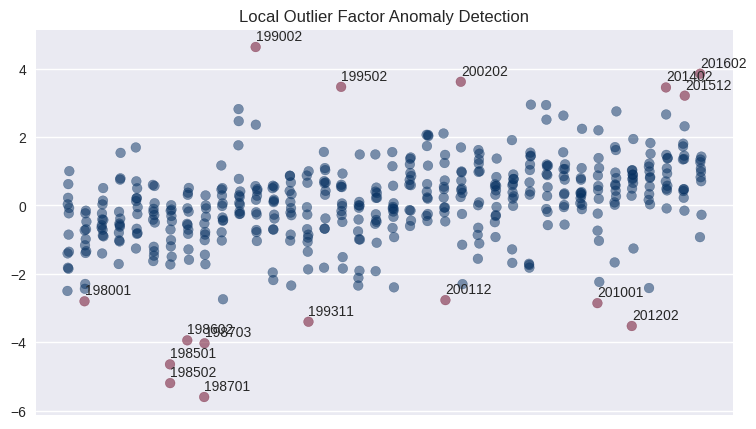

In [ ]:
plt.style.use("seaborn")
fig, ax = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax.scatter(dt['Month'], dt['European'],c=dt['LOF_anomaly'],cmap='RdBu',alpha=0.5 )
ax.set_title("Local Outlier Factor Anomaly Detection")

for anomaly in dt[dt['LOF_anomaly'] == -1]['Month']:
    ax.annotate(anomaly, xy=(anomaly, dt[dt['Month'] == anomaly]['European']),
                 xytext=(anomaly,dt[dt['Month'] == anomaly]['European'] + 0.2))
ax.get_xaxis().set_visible(False)

In [ ]:
dt.head()

,Month,European,colors,LOF_anomaly_scores,LOF_anomaly
0,197901,-2.5024,r,-1.363660,1
1,197902,-1.4039,b,-1.035618,1
2,197903,0.0308,b,-0.984214,1
3,197904,-1.8235,b,-1.018749,1
4,197905,0.2225,b,-1.001923,1


In [ ]:
dt.LOF_anomaly.unique()

array([ 1, -1])

Percobaan Kedua dengan memasukkan nilai n-neighbors = 10

In [ ]:
model_LOF_10 = LocalOutlierFactor(n_neighbors=10)
LOF_predictions_10 = model_LOF_10.fit_predict(dt[['European']])
model_LOF_scores_10= model_LOF_10.negative_outlier_factor_
dt['LOF_anomaly_score_10'] = model_LOF_scores_10
dt['LOF_anomaly_10'] = LOF_predictions_10

In [ ]:
dt.head()

,Month,European,colors,LOF_anomaly_scores,LOF_anomaly,LOF_anomaly_score_10,LOF_anomaly_10
0,197901,-2.5024,r,-1.363660,1,-1.053947,1
1,197902,-1.4039,b,-1.035618,1,-1.005606,1
2,197903,0.0308,b,-0.984214,1,-1.044360,1
3,197904,-1.8235,b,-1.018749,1,-0.980808,1
4,197905,0.2225,b,-1.001923,1,-0.959229,1


<ipython-input-195-b174d1ec5bbd>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


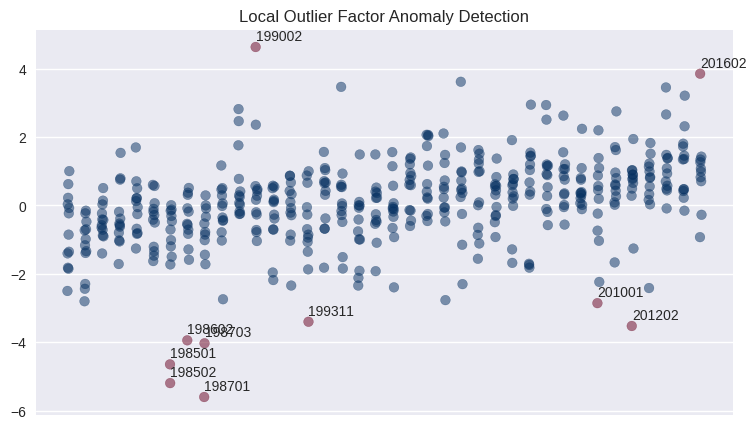

In [ ]:
plt.style.use("seaborn")
fig, ax2 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax2.scatter(dt['Month'], dt['European'],c=dt['LOF_anomaly_10'],cmap='RdBu',alpha=0.5 )
ax2.set_title("Local Outlier Factor Anomaly Detection")

for anomaly in dt[dt['LOF_anomaly_10'] == -1]['Month']:
    ax2.annotate(anomaly, xy=(anomaly, dt[dt['Month'] == anomaly]['European']),
                 xytext=(anomaly,dt[dt['Month'] == anomaly]['European'] + 0.2))
ax2.get_xaxis().set_visible(False)

##IFOREST METHOD

In [ ]:
dtif = dataku.drop(columns='Global', axis=1)
dtif.head()

,Month,European
0,197901,-2.5024
1,197902,-1.4039
2,197903,0.0308
3,197904,-1.8235
4,197905,0.2225


Percobaan Pertama

In [ ]:
from sklearn.ensemble import IsolationForest
model_IF = IsolationForest()
model_IF.fit(dtif[['European']])
dtif['IF_anomaly_scores'] = model_IF.decision_function(dtif[['European']])
dtif['IF_anomaly'] = model_IF.predict(dtif[['European']])

In [ ]:
dtif.head()

,Month,European,IF_anomaly_scores,IF_anomaly
0,197901,-2.5024,-0.085414,-1
1,197902,-1.4039,0.010560,1
2,197903,0.0308,0.082998,1
3,197904,-1.8235,-0.012815,-1
4,197905,0.2225,0.081963,1


<ipython-input-199-df35c0f36aed>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


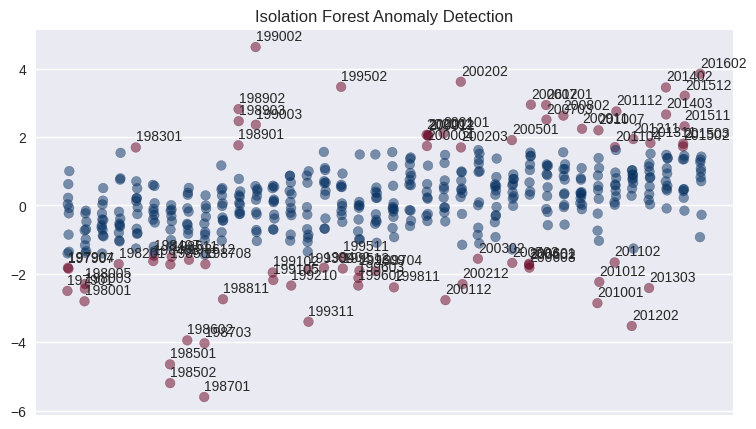

In [ ]:
plt.style.use("seaborn")
fig, ax3 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax3.scatter(dtif['Month'], dtif['European'],c=dtif['IF_anomaly'],cmap='RdBu',alpha=0.5 )
ax3.set_title("Isolation Forest Anomaly Detection")

for anomaly in dtif[dtif['IF_anomaly'] == -1]['Month']:
    ax3.annotate(anomaly, xy=(anomaly, dtif[dtif['Month'] == anomaly]['European']),
                 xytext=(anomaly,dtif[dtif['Month'] == anomaly]['European'] + 0.2))
ax3.get_xaxis().set_visible(False)

Percobaan Kedua dengan memasukkan nilai contamination = 0.05

In [ ]:
model_IF_05 = IsolationForest(contamination=float(.05))
model_IF_05.fit(dtif[['European']])
dtif['IF_anomaly_scores_05'] = model_IF_05.decision_function(dtif[['European']])
dtif['IF_anomaly_05'] = model_IF_05.predict(dtif[['European']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
dtif.head()

,Month,European,IF_anomaly_scores,IF_anomaly,IF_anomaly_scores_05,IF_anomaly_05
0,197901,-2.5024,-0.085414,-1,0.017213,1
1,197902,-1.4039,0.010560,1,0.096433,1
2,197903,0.0308,0.082998,1,0.186897,1
3,197904,-1.8235,-0.012815,-1,0.097391,1
4,197905,0.2225,0.081963,1,0.190515,1


<ipython-input-202-af459bc106d3>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


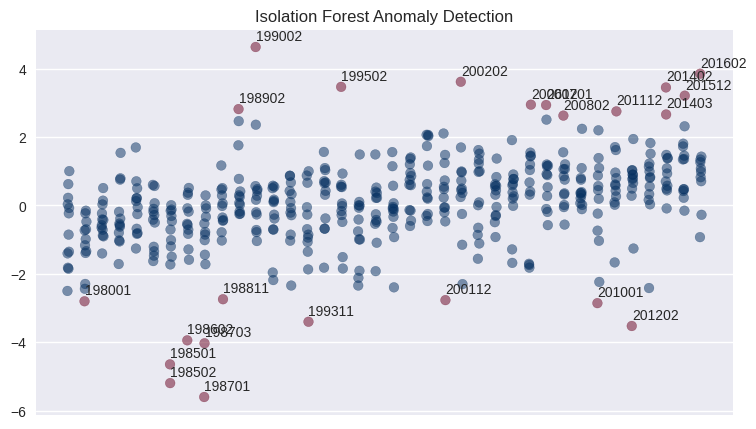

In [ ]:
plt.style.use("seaborn")
fig, ax4 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax4.scatter(dtif['Month'], dtif['European'],c=dtif['IF_anomaly_05'],cmap='RdBu',alpha=0.5 )
ax4.set_title("Isolation Forest Anomaly Detection")

for anomaly in dtif[dtif['IF_anomaly_05'] == -1]['Month']:
    ax4.annotate(anomaly, xy=(anomaly, dtif[dtif['Month'] == anomaly]['European']),
                 xytext=(anomaly,dtif[dtif['Month'] == anomaly]['European'] + 0.2))
ax4.get_xaxis().set_visible(False)

##ONE-CLASS SVM METHOD

In [ ]:
dtsvm = dataku.drop(columns='Global', axis=1)
dtsvm.head()

,Month,European
0,197901,-2.5024
1,197902,-1.4039
2,197903,0.0308
3,197904,-1.8235
4,197905,0.2225


In [ ]:
from sklearn.svm import OneClassSVM

model_SVM_05 = OneClassSVM(nu=0.05)
model_SVM_05.fit(dtsvm[['European']])
dtsvm['SVM_anomaly_scores'] = model_SVM_05.decision_function(dtsvm[['European']])
dtsvm['SVM_anomaly'] = model_SVM_05.predict(dtsvm[['European']])

<ipython-input-205-664899efca26>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


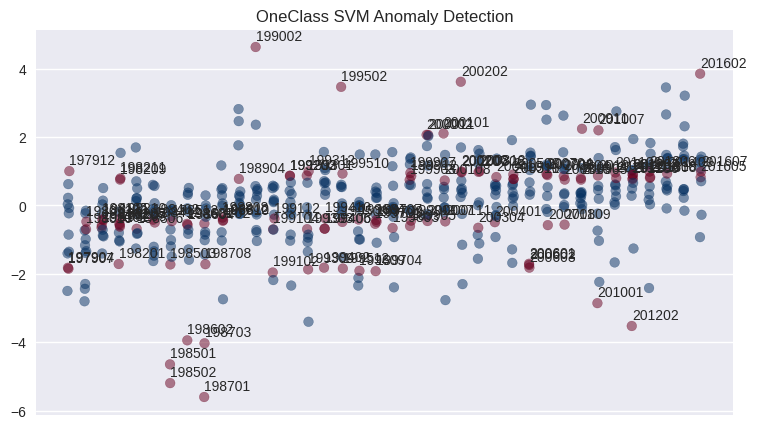

In [ ]:
plt.style.use("seaborn")
fig, ax5 = plt.subplots(1, figsize=(9, 5), sharex=True, sharey=False)
ax5.scatter(dtsvm['Month'], dtsvm['European'],c=dtsvm['SVM_anomaly'],cmap='RdBu',alpha=0.5 )
ax5.set_title("OneClass SVM Anomaly Detection")

for anomaly in dtsvm[dtsvm['SVM_anomaly'] == -1]['Month']:
    ax5.annotate(anomaly, xy=(anomaly, dtsvm[dtsvm['Month'] == anomaly]['European']),
                 xytext=(anomaly,dtsvm[dtsvm['Month'] == anomaly]['European'] + 0.2))
ax5.get_xaxis().set_visible(False)

In [ ]:
dtsvm.head()

,Month,European,SVM_anomaly_scores,SVM_anomaly
0,197901,-2.5024,0.000598,1
1,197902,-1.4039,0.000527,1
2,197903,0.0308,0.000887,1
3,197904,-1.8235,-0.000117,-1
4,197905,0.2225,0.001094,1


##SCORE ACURRATION

Akurasi LOF tanpa membatasi n-neighbors

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Ambang batas untuk mengklasifikasikan sampel sebagai anomali
threshold = np.percentile(dt['LOF_anomaly_scores'], 95)

# Mengklasifikasikan sampel berdasarkan ambang batas
dt['LOF_predicted'] = (dt['LOF_anomaly_scores'] < threshold).astype(int)

# Menghitung akurasi
accuracy = (dt['LOF_predicted'] == dt['LOF_anomaly']).mean()

# Menghitung nilai presisi
precision = precision_score(dt['LOF_anomaly'], dt['LOF_predicted'], average='weighted')

# Menghitung nilai recall
recall = recall_score(dt['LOF_anomaly'], dt['LOF_predicted'], average='weighted')

# Menghitung nilai F1 score
f1 = f1_score(dt['LOF_anomaly'], dt['LOF_predicted'], average='weighted')

# Menampilkan hasil
print(f'Akurasi: {accuracy * 100:.2f}%')
print(f'Presisi: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Akurasi: 91.41%
Presisi: 92.89%
Recall: 91.41%
F1 Score: 92.15%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Akurasi LOF dengan n-neighbors=10

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Ambang batas untuk mengklasifikasikan sampel sebagai anomali
threshold = np.percentile(dt['LOF_anomaly_score_10'], 90)

# Mengklasifikasikan sampel berdasarkan ambang batas
dt['LOF_predicted_10'] = (dt['LOF_anomaly_score_10'] < threshold).astype(int)

# Menghitung akurasi
accuracy = (dt['LOF_predicted_10'] == dt['LOF_anomaly_10']).mean()

# Menghitung nilai presisi
precision = precision_score(dt['LOF_anomaly_10'], dt['LOF_predicted_10'], average='weighted')

# Menghitung nilai recall
recall = recall_score(dt['LOF_anomaly_10'], dt['LOF_predicted_10'], average='weighted')

# Menghitung nilai F1 score
f1 = f1_score(dt['LOF_anomaly_10'], dt['LOF_predicted_10'], average='weighted')

print(f'Akurasi: {accuracy * 100:.2f}%')
print(f'Presisi: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Akurasi: 87.67%
Presisi: 95.40%
Recall: 87.67%
F1 Score: 91.37%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Akurasi IF tanpa membatasi contaminations

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Ambang batas untuk mengklasifikasikan sampel sebagai anomali
threshold = np.percentile(dtif['IF_anomaly_scores'], 95)

# Mengklasifikasikan sampel berdasarkan ambang batas
dtif['IF_predicted'] = (dtif['IF_anomaly_scores'] < threshold).astype(int)

# Menghitung akurasi
accuracy = (dtif['IF_predicted'] == dtif['IF_anomaly']).mean()

# Menghitung nilai presisi
precision = precision_score(dtif['IF_anomaly'], dtif['IF_predicted'], average='weighted')

# Menghitung nilai recall
recall = recall_score(dtif['IF_anomaly'], dtif['IF_predicted'], average='weighted')

# Menghitung nilai F1 score
f1 = f1_score(dtif['IF_anomaly'], dtif['IF_predicted'], average='weighted')

print(f'Akurasi: {accuracy * 100:.2f}%')
print(f'Presisi: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Akurasi: 78.19%
Presisi: 68.58%
Recall: 78.19%
F1 Score: 73.07%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Akurasi IF dengan contaminations=0.05

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Ambang batas untuk mengklasifikasikan sampel sebagai anomali
threshold = np.percentile(dtif['IF_anomaly_scores_05'], 95)

# Mengklasifikasikan sampel berdasarkan ambang batas
dtif['IF_predicted_05'] = (dtif['IF_anomaly_scores_05'] < threshold).astype(int)

# Menghitung akurasi
accuracy = (dtif['IF_predicted_05'] == dtif['IF_anomaly_05']).mean()

# Menghitung nilai presisi
precision = precision_score(dtif['IF_anomaly_05'], dtif['IF_predicted_05'], average='weighted')

# Menghitung nilai recall
recall = recall_score(dtif['IF_anomaly_05'], dtif['IF_predicted_05'], average='weighted')

# Menghitung nilai F1 score
f1 = f1_score(dtif['IF_anomaly_05'], dtif['IF_predicted_05'], average='weighted')

print(f'Akurasi: {accuracy * 100:.2f}%')
print(f'Presisi: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Akurasi: 89.87%
Presisi: 89.87%
Recall: 89.87%
F1 Score: 89.87%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Akurasi SVM dengan nu=0.05

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Ambang batas untuk mengklasifikasikan sampel sebagai anomali
threshold = np.percentile(model_SVM_05.decision_function(dtsvm[['European']]), 95)

# Mengklasifikasikan sampel berdasarkan ambang batas
dtsvm['SVM_predicted'] = (dtsvm['SVM_anomaly_scores'] < threshold).astype(int)

# Menghitung akurasi
accuracy = (dtsvm['SVM_predicted'] == dtsvm['SVM_anomaly']).mean()

# Menghitung nilai presisi
precision = precision_score(dtsvm['SVM_anomaly'], dtsvm['SVM_predicted'], average='weighted')

# Menghitung nilai recall
recall = recall_score(dtsvm['SVM_anomaly'], dtsvm['SVM_predicted'], average='weighted')

# Menghitung nilai F1 score
f1 = f1_score(dtsvm['SVM_anomaly'], dtsvm['SVM_predicted'], average='weighted')

print(f'Akurasi: {accuracy * 100:.2f}%')
print(f'Presisi: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Akurasi: 70.70%
Presisi: 56.43%
Recall: 70.70%
F1 Score: 62.77%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##CONCLUSION

Tujuan pembangunan model adalah untuk mendeteksi adanya anomali atau outlier yang ada pada dataset. model dibangun dengan menggunakan beberapa algoritma dan masing masing algoritma menghasilkan akurasi sebagai berikut :
1. Algoritma Local Outlier Factor(LOF) dengan n-neighbors default (20) menghasilkan:
*   Akurasi: 91.41%
*   Presisi: 92.89%
*   Recall: 91.41%
*   F1 Score: 92.15%

2. Algoritma Local Outlier Factor (LOF) dengan n-neighbors = 10 menghasilkan:
*   Akurasi: 87.67%
*   Presisi: 95.40%
*   Recall: 87.67%
*   F1 Score: 91.37%

3. Algoritma Isolation Forest (IF) dengan contaminatios default (0.5) menghasilkan:
*   Akurasi: 78.41%
*   Presisi: 68.95%
*   Recall: 78.41%
*   F1 Score: 73.38%

4. Algoritma Isolation Forest (IF) dengan contaminatios = 0.05 menghasilkan:
*   Akurasi: 89.87%
*   Presisi: 89.87%
*   Recall: 89.87%
*   F1 Score: 89.87%

5. Algoritma One Class SVM dengan nu = 0.05 menghasilkan:
*   Akurasi: 70.70%
*   Presisi: 56.43%
*   Recall: 70.70%
*   F1 Score: 62.77%